# 資料挖掘作業 2：吸菸預測模型

本專案透過多個機器學習模型的集成方法來預測吸菸狀態。我們使用了三種強大的梯度提升樹模型：XGBoost、LightGBM 和 CatBoost，並透過 Optuna 進行超參數優化，最後根據驗證集上的 AUC 得分進行加權集成。

## 1. 導入所需套件

首先導入所有需要使用的套件和函式庫。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from datetime import datetime
import optuna
import shap
import time
import warnings

warnings.filterwarnings("ignore")
start_time = time.time()

c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 資料載入與探索

在這個部分，我們載入訓練和測試資料集，並進行初步的資料探索。

In [2]:
# 載入資料集
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# 顯示訓練集的基本資訊
print(f"訓練集形狀: {train.shape}")
print(f"測試集形狀: {test.shape}")
train.head()

訓練集形狀: (15000, 24)
測試集形狀: (10000, 23)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,25.0,170.0,60.0,75.0,1.5,1.2,1.0,1.0,100.0,...,50.0,81.0,15.2,1.0,0.8,18.0,16.0,19.0,1.0,1.0
1,1,40.0,165.0,65.0,79.0,1.0,1.2,1.0,1.0,130.0,...,58.0,130.0,12.8,1.0,0.6,31.0,26.0,33.0,0.0,0.0
2,2,50.0,170.0,80.0,93.0,1.2,1.0,1.0,1.0,130.0,...,44.0,130.0,16.7,1.0,0.9,38.0,46.0,69.0,0.0,1.0
3,3,75.0,160.0,60.0,89.0,0.8,1.0,1.0,1.0,116.0,...,44.0,149.0,15.1,1.0,1.1,24.0,22.0,20.0,0.0,0.0
4,4,60.0,170.0,75.0,89.0,0.8,0.8,1.0,1.0,138.0,...,38.0,122.0,14.6,1.0,1.0,26.0,27.0,97.0,0.0,1.0


In [9]:
# 檢查訓練集和測試集的缺失值
print("訓練集缺失值統計:")
missing_train = train.isnull().sum()
missing_percentage_train = 100 * missing_train / len(train)
missing_info_train = pd.concat([missing_train, missing_percentage_train], axis=1)
missing_info_train.columns = ['缺失值數量', '缺失百分比 (%)']
missing_info_train = missing_info_train[missing_info_train['缺失值數量'] > 0]
print(missing_info_train if not missing_info_train.empty else "訓練集無缺失值")

print("\n測試集缺失值統計:")
missing_test = test.isnull().sum()
missing_percentage_test = 100 * missing_test / len(test)
missing_info_test = pd.concat([missing_test, missing_percentage_test], axis=1)
missing_info_test.columns = ['缺失值數量', '缺失百分比 (%)']
missing_info_test = missing_info_test[missing_info_test['缺失值數量'] > 0]
print(missing_info_test if not missing_info_test.empty else "測試集無缺失值")

訓練集缺失值統計:
訓練集無缺失值

測試集缺失值統計:
         缺失值數量  缺失百分比 (%)
smoking  10000      100.0


## 3. 資料前處理

資料前處理是機器學習流程中非常重要的一環。在這一部分，我們將執行以下步驟：
1. 合併訓練集和測試集以進行一致的特徵工程
2. 處理欄位名稱（替換空格為下劃線）
3. 辨識並分類特徵（類別型和數值型）
4. 進行缺失值處理和特徵轉換

In [16]:
# 合併訓練集和測試集以統一進行特徵處理
test['smoking'] = np.nan
data = pd.concat([train, test], ignore_index=True)
data.columns = data.columns.str.replace(' ', '_')

# 定義類別型和數值型特徵
categorical_columns = ['hearing(left)', 'hearing(right)', 'Urine_protein', 'dental_caries']
#categorical_columns = [col.replace(' ', '_') for col in categorical_columns]
numerical_columns = [col for col in data.columns if col not in categorical_columns + ['smoking', 'id']
                     and data[col].dtype in ['float64', 'int64']]

# 顯示分類後的特徵數量
print(f"類別型特徵數量: {len(categorical_columns)}")
print(f"數值型特徵數量: {len(numerical_columns)}")

類別型特徵數量: 4
數值型特徵數量: 18


### 3.1 缺失值處理與特徵轉換

我們使用以下方法處理資料：
1. 使用 SimpleImputer 填補缺失值（以中位數填補）
2. 應用 Yeo-Johnson 變換來處理偏態分佈
3. 使用 MinMaxScaler 將數值特徵縮放到相同範圍

In [17]:

# 應用 Power Transform 處理偏態分佈
power_transformer = PowerTransformer(method='yeo-johnson')
data[numerical_columns] = power_transformer.fit_transform(data[numerical_columns])

# 特徵縮放
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
data[numerical_columns]

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting_blood_sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum_creatinine,AST,ALT,Gtp
0,0.101583,0.605789,0.518258,0.353051,0.249026,0.214614,0.301288,0.180663,0.658387,0.195736,0.390124,0.416537,0.243426,0.588170,0.257086,0.351204,0.542899,0.812081
1,0.368570,0.512626,0.577845,0.420489,0.172159,0.214614,0.581085,0.466731,0.714591,0.524759,0.349018,0.520100,0.527522,0.380474,0.132128,0.627018,0.680109,0.866428
2,0.525660,0.605789,0.732040,0.641994,0.204065,0.184173,0.581085,0.466731,0.636322,0.524759,0.676192,0.328316,0.527522,0.747966,0.317241,0.706429,0.810075,0.920591
3,0.873607,0.421645,0.518258,0.580817,0.138421,0.184173,0.453792,0.354241,0.759118,0.634515,0.725129,0.328316,0.624988,0.578365,0.433470,0.509808,0.635848,0.817703
4,0.671300,0.605789,0.684176,0.580817,0.138421,0.152098,0.651591,0.438827,0.703244,0.555582,0.855786,0.228282,0.484704,0.530883,0.376002,0.548712,0.689698,0.939863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.599727,0.512626,0.518258,0.403820,0.155538,0.168356,0.581085,0.195375,0.740546,0.585720,0.849705,0.482903,0.435095,0.588170,0.376002,0.412873,0.578624,0.871465
24996,0.368570,0.421645,0.453400,0.420489,0.249026,0.214614,0.581085,0.590635,0.720049,0.620058,0.716125,0.430284,0.584628,0.692009,0.317241,0.233847,0.448756,0.817703
24997,0.195901,0.605789,0.632944,0.410502,0.155538,0.168356,0.490702,0.340009,0.703244,0.493212,0.827535,0.470087,0.360400,0.681145,0.317241,0.351204,0.635848,0.817703
24998,0.368570,0.512626,0.518258,0.335866,0.249026,0.214614,0.435165,0.354241,0.556982,0.514325,0.543257,0.621902,0.435095,0.403381,0.132128,0.383390,0.500431,0.755992


### 3.2 類別型特徵編碼與特徵工程

在這個部分，我們將：
1. 對類別型特徵進行 One-Hot 編碼
2. 應用 KMeans 聚類作為特徵工程的一部分，創建新的聚類特徵

In [21]:
categorical_columns

['hearing(left)', 'hearing(right)', 'Urine_protein', 'dental_caries']

In [22]:
numerical_columns

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'systolic',
 'relaxation',
 'fasting_blood_sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'serum_creatinine',
 'AST',
 'ALT',
 'Gtp']

In [20]:
# One-Hot 編碼
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(data[categorical_columns])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_columns), index=data.index)
data = data.drop(columns=categorical_columns)
data = pd.concat([data, encoded_df], axis=1)

# 使用 KMeans 進行聚類特徵工程
kmeans = KMeans(n_clusters=5, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(data[numerical_columns])

# 檢視特徵工程後的資料
print(f"處理後的特徵數量: {data.shape[1]}")
data.head()

處理後的特徵數量: 28


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting_blood_sugar,...,Gtp,smoking,hearing(left)_2.0,hearing(right)_2.0,Urine_protein_2.0,Urine_protein_3.0,Urine_protein_4.0,Urine_protein_5.0,dental_caries_1.0,kmeans_cluster
0,0,0.101583,0.605789,0.518258,0.353051,0.249026,0.214614,0.301288,0.180663,0.658387,...,0.812081,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,1,0.368570,0.512626,0.577845,0.420489,0.172159,0.214614,0.581085,0.466731,0.714591,...,0.866428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,0.525660,0.605789,0.732040,0.641994,0.204065,0.184173,0.581085,0.466731,0.636322,...,0.920591,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,3,0.873607,0.421645,0.518258,0.580817,0.138421,0.184173,0.453792,0.354241,0.759118,...,0.817703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,4,0.671300,0.605789,0.684176,0.580817,0.138421,0.152098,0.651591,0.438827,0.703244,...,0.939863,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## 4. 資料分割

將資料分割為訓練集、驗證集和測試集。這是模型訓練和評估的重要步驟。

In [37]:
# 分割資料
train_length = len(train)
X = data.iloc[:train_length].drop(columns=['smoking', 'id'])
X_test = data.iloc[train_length:].drop(columns=['smoking', 'id'])
y = data.iloc[:train_length]['smoking'].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
features = X.columns

# 檢視分割後的資料集大小
print(f"訓練集: {X_train.shape}")
print(f"驗證集: {X_val.shape}")
print(f"測試集: {X_test.shape}")

訓練集: (13500, 26)
驗證集: (1500, 26)
測試集: (10000, 26)


## 5. 模型超參數優化與訓練

在這個部分，我們將使用 Optuna 來為三種不同的梯度提升樹模型尋找最佳的超參數。超參數優化是提高模型性能的關鍵步驟。

### 5.1 XGBoost 模型優化與訓練

XGBoost 是一種高效能的梯度提升樹實現，特別適合結構化/表格式資料。

In [38]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'auc'
    }
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", auc)
    return auc

# 創建並執行 Optuna 研究對象
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

# 顯示最佳參數
print("最佳 XGBoost 參數:")
print(study_xgb.best_params)
print(f"最佳 AUC: {study_xgb.best_value:.4f}")

# 使用最佳參數訓練模型
best_xgb = xgb.XGBClassifier(**study_xgb.best_params, tree_method='hist', device='cuda', eval_metric='logloss')
best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
xgb_log = best_xgb.evals_result()
xgb_preds = best_xgb.predict_proba(X_test)[:, 1]

[I 2025-04-10 22:27:57,747] A new study created in memory with name: no-name-6178f156-8f3b-423d-a59f-75e3aaad7592
[I 2025-04-10 22:28:02,917] Trial 0 finished with value: 0.8850879807986303 and parameters: {'n_estimators': 854, 'max_depth': 5, 'learning_rate': 0.12977086448615027, 'subsample': 0.6539619570643472, 'colsample_bytree': 0.8046187073201703, 'min_child_weight': 8, 'gamma': 2.065485490094226, 'reg_alpha': 4.383777457861473, 'reg_lambda': 0.6936568825699901}. Best is trial 0 with value: 0.8850879807986303.
[I 2025-04-10 22:28:07,902] Trial 1 finished with value: 0.8746178071301902 and parameters: {'n_estimators': 440, 'max_depth': 10, 'learning_rate': 0.195512516316269, 'subsample': 0.8829235052823896, 'colsample_bytree': 0.7859017315089593, 'min_child_weight': 4, 'gamma': 0.14611361232004738, 'reg_alpha': 3.9858370308711706, 'reg_lambda': 2.5204907083645045}. Best is trial 0 with value: 0.8850879807986303.
[I 2025-04-10 22:28:09,189] Trial 2 finished with value: 0.88768880327

最佳 XGBoost 參數:
{'n_estimators': 498, 'max_depth': 9, 'learning_rate': 0.06166934729350603, 'subsample': 0.7092697130995336, 'colsample_bytree': 0.8702282530272064, 'min_child_weight': 7, 'gamma': 4.039952659630737, 'reg_alpha': 1.4505130062166967, 'reg_lambda': 4.919991548728598}
最佳 AUC: 0.8887


### 5.2 LightGBM 模型優化與訓練

LightGBM 是一個高效、低記憶體佔用的梯度提升框架，使用基於直方圖的分割尋找策略，適合大型資料集。

In [39]:
def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'device_type': 'gpu',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0)
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(30)])
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", auc)
    return auc

# 創建並執行 Optuna 研究對象
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

# 顯示最佳參數
print("最佳 LightGBM 參數:")
print(study_lgb.best_params)
print(f"最佳 AUC: {study_lgb.best_value:.4f}")

# 使用最佳參數訓練模型
best_lgb = LGBMClassifier(**study_lgb.best_params, verbosity=-1)
best_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc', callbacks=[lgb.early_stopping(30)])
lgb_log = best_lgb.evals_result_
lgb_preds = best_lgb.predict_proba(X_test)[:, 1]

[I 2025-04-10 22:29:59,991] A new study created in memory with name: no-name-98219799-8a82-4ded-967b-7f8be556d86b


Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:30:19,062] Trial 0 finished with value: 0.8863740598055403 and parameters: {'n_estimators': 668, 'learning_rate': 0.03539640505293164, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.8786022676304965, 'colsample_bytree': 0.6250364819140742, 'reg_alpha': 4.66775063997925, 'reg_lambda': 0.7151315624323057}. Best is trial 0 with value: 0.8863740598055403.


Early stopping, best iteration is:
[160]	valid_0's auc: 0.886374
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:30:24,799] Trial 1 finished with value: 0.8883519079068061 and parameters: {'n_estimators': 190, 'learning_rate': 0.1071277762194415, 'num_leaves': 46, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.690691378671765, 'colsample_bytree': 0.9365937931164292, 'reg_alpha': 1.8412278768133299, 'reg_lambda': 0.5885135366774119}. Best is trial 1 with value: 0.8883519079068061.


Early stopping, best iteration is:
[68]	valid_0's auc: 0.888352
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:30:30,143] Trial 2 finished with value: 0.8873467406592063 and parameters: {'n_estimators': 498, 'learning_rate': 0.19132059954003944, 'num_leaves': 147, 'max_depth': 11, 'min_child_samples': 89, 'subsample': 0.9445482879294889, 'colsample_bytree': 0.6761767110423703, 'reg_alpha': 1.8949182403505693, 'reg_lambda': 1.5565659853853404}. Best is trial 1 with value: 0.8883519079068061.


Early stopping, best iteration is:
[48]	valid_0's auc: 0.887347
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:30:34,943] Trial 3 finished with value: 0.8866607044578976 and parameters: {'n_estimators': 306, 'learning_rate': 0.1075310365003411, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 56, 'subsample': 0.9665578390645165, 'colsample_bytree': 0.8284309377946126, 'reg_alpha': 3.3814514012444548, 'reg_lambda': 4.983257694867313}. Best is trial 1 with value: 0.8883519079068061.


Early stopping, best iteration is:
[113]	valid_0's auc: 0.886661
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:30:40,899] Trial 4 finished with value: 0.8890303002507185 and parameters: {'n_estimators': 322, 'learning_rate': 0.10537014062881764, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 46, 'subsample': 0.7480304961687906, 'colsample_bytree': 0.8141036561951116, 'reg_alpha': 2.295707461618639, 'reg_lambda': 1.1982331389266294}. Best is trial 4 with value: 0.8890303002507185.


Early stopping, best iteration is:
[208]	valid_0's auc: 0.88903
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:30:46,109] Trial 5 finished with value: 0.8878474133186571 and parameters: {'n_estimators': 613, 'learning_rate': 0.12924036492050242, 'num_leaves': 73, 'max_depth': 3, 'min_child_samples': 42, 'subsample': 0.6467195761403558, 'colsample_bytree': 0.7956748207168327, 'reg_alpha': 3.526660460599334, 'reg_lambda': 3.6646750452028143}. Best is trial 4 with value: 0.8890303002507185.


Early stopping, best iteration is:
[169]	valid_0's auc: 0.887847
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:30:50,554] Trial 6 finished with value: 0.8869970341833302 and parameters: {'n_estimators': 194, 'learning_rate': 0.10230217403411992, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 55, 'subsample': 0.8328601172779686, 'colsample_bytree': 0.895770996926448, 'reg_alpha': 1.480898178785578, 'reg_lambda': 0.07621588215099118}. Best is trial 4 with value: 0.8890303002507185.


Early stopping, best iteration is:
[77]	valid_0's auc: 0.886997
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:06,105] Trial 7 finished with value: 0.886790650033633 and parameters: {'n_estimators': 911, 'learning_rate': 0.04749621239491452, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.7460974336831188, 'colsample_bytree': 0.7631505007410958, 'reg_alpha': 4.539644724706948, 'reg_lambda': 0.895883845839438}. Best is trial 4 with value: 0.8890303002507185.


Early stopping, best iteration is:
[188]	valid_0's auc: 0.886791
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:09,412] Trial 8 finished with value: 0.885860010395646 and parameters: {'n_estimators': 485, 'learning_rate': 0.13791573124116735, 'num_leaves': 117, 'max_depth': 5, 'min_child_samples': 69, 'subsample': 0.9313804328787654, 'colsample_bytree': 0.7465766050817533, 'reg_alpha': 3.9777243035882313, 'reg_lambda': 4.727407159218366}. Best is trial 4 with value: 0.8890303002507185.


Early stopping, best iteration is:
[83]	valid_0's auc: 0.88586
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:13,779] Trial 9 finished with value: 0.8890341221794166 and parameters: {'n_estimators': 393, 'learning_rate': 0.1853305229994786, 'num_leaves': 51, 'max_depth': 5, 'min_child_samples': 84, 'subsample': 0.8620013130919459, 'colsample_bytree': 0.8949663277054292, 'reg_alpha': 3.8697609875869263, 'reg_lambda': 3.183094511309056}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[120]	valid_0's auc: 0.889034
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:16,773] Trial 10 finished with value: 0.8847726716810371 and parameters: {'n_estimators': 798, 'learning_rate': 0.18234688629704845, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 100, 'subsample': 0.855096190301884, 'colsample_bytree': 0.8926086218517714, 'reg_alpha': 0.19813354275105333, 'reg_lambda': 2.8976826480216573}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[37]	valid_0's auc: 0.884773
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:21,178] Trial 11 finished with value: 0.888000290466581 and parameters: {'n_estimators': 353, 'learning_rate': 0.16081772491239404, 'num_leaves': 54, 'max_depth': 3, 'min_child_samples': 77, 'subsample': 0.7619876326196864, 'colsample_bytree': 0.9974363579903459, 'reg_alpha': 2.836973444212306, 'reg_lambda': 2.04293483802823}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[146]	valid_0's auc: 0.888
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:28,354] Trial 12 finished with value: 0.8865823549195866 and parameters: {'n_estimators': 371, 'learning_rate': 0.0663575886415353, 'num_leaves': 97, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.78113440935859, 'colsample_bytree': 0.8357685677131838, 'reg_alpha': 0.8157600267053917, 'reg_lambda': 3.224408836390793}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[194]	valid_0's auc: 0.886582
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:31,396] Trial 13 finished with value: 0.8844611844921422 and parameters: {'n_estimators': 109, 'learning_rate': 0.07338018369473816, 'num_leaves': 62, 'max_depth': 4, 'min_child_samples': 67, 'subsample': 0.7193111713533582, 'colsample_bytree': 0.8705681663900487, 'reg_alpha': 2.5518729061931458, 'reg_lambda': 2.2664220042225436}. Best is trial 9 with value: 0.8890341221794166.


Did not meet early stopping. Best iteration is:
[108]	valid_0's auc: 0.884461
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:49,558] Trial 14 finished with value: 0.8835630312480889 and parameters: {'n_estimators': 447, 'learning_rate': 0.015970216117519406, 'num_leaves': 150, 'max_depth': 6, 'min_child_samples': 40, 'subsample': 0.8229490114260251, 'colsample_bytree': 0.9539351608948494, 'reg_alpha': 3.112772193487881, 'reg_lambda': 4.031241181759411}. Best is trial 9 with value: 0.8890341221794166.


Did not meet early stopping. Best iteration is:
[447]	valid_0's auc: 0.883563
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:53,475] Trial 15 finished with value: 0.8878970983917324 and parameters: {'n_estimators': 252, 'learning_rate': 0.16059926665160215, 'num_leaves': 97, 'max_depth': 4, 'min_child_samples': 81, 'subsample': 0.6109626267126664, 'colsample_bytree': 0.7232224788560683, 'reg_alpha': 3.939609356794613, 'reg_lambda': 1.898376110018257}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[129]	valid_0's auc: 0.887897
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:31:56,694] Trial 16 finished with value: 0.884336971809454 and parameters: {'n_estimators': 612, 'learning_rate': 0.16028364392348435, 'num_leaves': 22, 'max_depth': 8, 'min_child_samples': 63, 'subsample': 0.8949084042223054, 'colsample_bytree': 0.7995876783881379, 'reg_alpha': 2.130358838720049, 'reg_lambda': 1.4160587193545682}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[66]	valid_0's auc: 0.884337
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:02,648] Trial 17 finished with value: 0.8854644407753929 and parameters: {'n_estimators': 398, 'learning_rate': 0.08366348602805862, 'num_leaves': 131, 'max_depth': 6, 'min_child_samples': 47, 'subsample': 0.6954783914246617, 'colsample_bytree': 0.8599379991004411, 'reg_alpha': 1.155151255365106, 'reg_lambda': 2.608248032773009}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[143]	valid_0's auc: 0.885464
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:09,389] Trial 18 finished with value: 0.8876754265272427 and parameters: {'n_estimators': 700, 'learning_rate': 0.1355338602219001, 'num_leaves': 93, 'max_depth': 4, 'min_child_samples': 32, 'subsample': 0.7943253156935759, 'colsample_bytree': 0.9282287642571663, 'reg_alpha': 3.948095823404005, 'reg_lambda': 4.159390069848412}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[220]	valid_0's auc: 0.887675
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:13,663] Trial 19 finished with value: 0.8845108695652173 and parameters: {'n_estimators': 275, 'learning_rate': 0.19467913092198313, 'num_leaves': 70, 'max_depth': 6, 'min_child_samples': 100, 'subsample': 0.9130546943743286, 'colsample_bytree': 0.9798317898250757, 'reg_alpha': 2.4509165439791727, 'reg_lambda': 3.028446799988373}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[84]	valid_0's auc: 0.884511
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:18,520] Trial 20 finished with value: 0.8879754479300433 and parameters: {'n_estimators': 545, 'learning_rate': 0.12480219315600721, 'num_leaves': 105, 'max_depth': 3, 'min_child_samples': 87, 'subsample': 0.8218920068947361, 'colsample_bytree': 0.7101932424945812, 'reg_alpha': 4.2782862557666945, 'reg_lambda': 1.280932050407755}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[167]	valid_0's auc: 0.887975
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:24,143] Trial 21 finished with value: 0.887803461138629 and parameters: {'n_estimators': 107, 'learning_rate': 0.11350640019291372, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.6806984727911497, 'colsample_bytree': 0.9295117082980966, 'reg_alpha': 1.9497124730873434, 'reg_lambda': 0.04209487054759786}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[76]	valid_0's auc: 0.887803
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:29,815] Trial 22 finished with value: 0.8861810524062863 and parameters: {'n_estimators': 205, 'learning_rate': 0.09451841062340703, 'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.7345066762376281, 'colsample_bytree': 0.9155531432590935, 'reg_alpha': 1.5349435689276822, 'reg_lambda': 0.7004350517107302}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[80]	valid_0's auc: 0.886181
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:33,097] Trial 23 finished with value: 0.884843377361952 and parameters: {'n_estimators': 205, 'learning_rate': 0.15020060876984362, 'num_leaves': 20, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.9995923052381476, 'colsample_bytree': 0.9537311264610402, 'reg_alpha': 2.492740971745417, 'reg_lambda': 0.38936646033121847}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[59]	valid_0's auc: 0.884843
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:43,469] Trial 24 finished with value: 0.8882124075093255 and parameters: {'n_estimators': 318, 'learning_rate': 0.06115621026409844, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.6691460175256964, 'colsample_bytree': 0.8391645691986556, 'reg_alpha': 0.9118996830239645, 'reg_lambda': 1.0431604514027184}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[162]	valid_0's auc: 0.888212
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:52,910] Trial 25 finished with value: 0.8856230508163639 and parameters: {'n_estimators': 412, 'learning_rate': 0.08961412596813616, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.6032651416782465, 'colsample_bytree': 0.8770799416337898, 'reg_alpha': 4.974111995766682, 'reg_lambda': 1.7922679047157801}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[95]	valid_0's auc: 0.885623
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:32:57,094] Trial 26 finished with value: 0.8870772946859903 and parameters: {'n_estimators': 160, 'learning_rate': 0.17568264851089646, 'num_leaves': 69, 'max_depth': 5, 'min_child_samples': 59, 'subsample': 0.7187800558017389, 'colsample_bytree': 0.7805183264111129, 'reg_alpha': 2.963404572005895, 'reg_lambda': 3.531365860301835}. Best is trial 9 with value: 0.8890341221794166.


Early stopping, best iteration is:
[73]	valid_0's auc: 0.887077
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:33:02,403] Trial 27 finished with value: 0.8891621567908029 and parameters: {'n_estimators': 249, 'learning_rate': 0.11582375925616807, 'num_leaves': 44, 'max_depth': 4, 'min_child_samples': 48, 'subsample': 0.6457302470675782, 'colsample_bytree': 0.9562931662084738, 'reg_alpha': 1.6332643946265961, 'reg_lambda': 0.4913548435472238}. Best is trial 27 with value: 0.8891621567908029.


Early stopping, best iteration is:
[176]	valid_0's auc: 0.889162
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:33:10,339] Trial 28 finished with value: 0.8893360545465664 and parameters: {'n_estimators': 280, 'learning_rate': 0.08018438064664042, 'num_leaves': 136, 'max_depth': 4, 'min_child_samples': 48, 'subsample': 0.6316774677386836, 'colsample_bytree': 0.9009776954822585, 'reg_alpha': 0.06462699480149192, 'reg_lambda': 2.4963234306376143}. Best is trial 28 with value: 0.8893360545465664.


Early stopping, best iteration is:
[230]	valid_0's auc: 0.889336
Training until validation scores don't improve for 30 rounds


[I 2025-04-10 22:33:18,008] Trial 29 finished with value: 0.8839471350822479 and parameters: {'n_estimators': 278, 'learning_rate': 0.037723982145132826, 'num_leaves': 137, 'max_depth': 3, 'min_child_samples': 73, 'subsample': 0.647762950529413, 'colsample_bytree': 0.6125392667747699, 'reg_alpha': 0.2252783773862452, 'reg_lambda': 2.7503408853302598}. Best is trial 28 with value: 0.8893360545465664.


Did not meet early stopping. Best iteration is:
[277]	valid_0's auc: 0.883947
最佳 LightGBM 參數:
{'n_estimators': 280, 'learning_rate': 0.08018438064664042, 'num_leaves': 136, 'max_depth': 4, 'min_child_samples': 48, 'subsample': 0.6316774677386836, 'colsample_bytree': 0.9009776954822585, 'reg_alpha': 0.06462699480149192, 'reg_lambda': 2.4963234306376143}
最佳 AUC: 0.8893
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[230]	valid_0's auc: 0.889336	valid_0's binary_logloss: 0.393228


### 5.3 CatBoost 模型優化與訓練

CatBoost 是一種高效能的梯度提升樹實現，尤其擅長處理類別型特徵，並自動處理缺失值。

In [40]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0,
        'eval_metric': 'AUC',
        'random_state': 42,
        'task_type': 'CPU',
        'od_type': 'Iter',
        'od_wait': 30
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", auc)
    return auc

# 創建並執行 Optuna 研究對象
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30)

# 顯示最佳參數
print("最佳 CatBoost 參數:")
print(study_cat.best_params)
print(f"最佳 AUC: {study_cat.best_value:.4f}")

# 使用最佳參數訓練模型
best_cat = CatBoostClassifier(**study_cat.best_params)
best_cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, verbose=False)
cat_log = best_cat.get_evals_result()
cat_preds = best_cat.predict_proba(X_test)[:, 1]

[I 2025-04-10 22:33:23,124] A new study created in memory with name: no-name-d29225ff-188d-4357-b291-ac111e8e4a9f
[I 2025-04-10 22:33:31,732] Trial 0 finished with value: 0.8850077202959702 and parameters: {'iterations': 443, 'learning_rate': 0.02427317821487375, 'depth': 4, 'l2_leaf_reg': 1.2760990380416792, 'bagging_temperature': 0.8597083890391739, 'border_count': 173}. Best is trial 0 with value: 0.8850077202959702.
[I 2025-04-10 22:33:36,777] Trial 1 finished with value: 0.886129456368862 and parameters: {'iterations': 940, 'learning_rate': 0.09526930220040082, 'depth': 7, 'l2_leaf_reg': 4.648505517326263, 'bagging_temperature': 0.36881783205624186, 'border_count': 99}. Best is trial 1 with value: 0.886129456368862.
[I 2025-04-10 22:33:40,726] Trial 2 finished with value: 0.887763330887299 and parameters: {'iterations': 447, 'learning_rate': 0.14640302311049636, 'depth': 5, 'l2_leaf_reg': 7.0585115442374695, 'bagging_temperature': 0.9604565225364752, 'border_count': 199}. Best is 

最佳 CatBoost 參數:
{'iterations': 816, 'learning_rate': 0.17046475221089244, 'depth': 3, 'l2_leaf_reg': 8.32997614523971, 'bagging_temperature': 0.5820722362026789, 'border_count': 224}
最佳 AUC: 0.8900


## 6. 模型集成與預測

在這部分，我們將根據各個模型在驗證集上的 AUC 表現，進行自動加權集成，結合三個模型的預測結果。

In [56]:
# 計算基於 AUC 的權重
auc_xgb = study_xgb.best_value or 0
auc_lgb = study_lgb.best_value or 0
auc_cat = study_cat.best_value or 0
#total_auc = auc_xgb + auc_lgb + auc_cat
total_auc = auc_xgb + auc_cat
w_xgb = auc_xgb / total_auc
#w_lgb = auc_lgb / total_auc
w_cat = auc_cat / total_auc

#print(f"使用自動 AUC 權重：XGB = {w_xgb:.4f}, LGB = {w_lgb:.4f}, CAT = {w_cat:.4f}")

# 加權集成預測
#final_preds = w_xgb * xgb_preds + w_lgb * lgb_preds + w_cat * cat_preds
final_preds = w_xgb * xgb_preds + w_cat * cat_preds
# 生成提交檔案
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'submission_{timestamp}.csv'
sample_submission['smoking'] = final_preds
sample_submission.to_csv(filename, index=False)
print(f"提交檔案已儲存為 {filename}")

提交檔案已儲存為 submission_20250410_224648.csv


## 7. 模型評估與分析

在這一部分，我們將通過各種方式分析模型性能和特徵重要性。

### 7.1 儲存 Optuna 超參數優化結果

記錄所有超參數優化試驗的結果，便於後續分析。

In [42]:
# 收集所有 Optuna 試驗結果
optuna_trials = []
for study, name in [(study_xgb, 'XGBoost'), (study_lgb, 'LightGBM'), (study_cat, 'CatBoost')]:
    for t in study.trials:
        optuna_trials.append({
            'model': name,
            'score': t.user_attrs.get('mean_auc', t.value),
            **t.user_attrs.get('params', {})
        })
pd.DataFrame(optuna_trials).to_csv('optuna_trials_log.csv', index=False)
print("超參數優化記錄已保存至 optuna_trials_log.csv")

超參數優化記錄已保存至 optuna_trials_log.csv


### 7.2 繪製訓練曲線

視覺化三個模型在訓練過程中的性能變化。

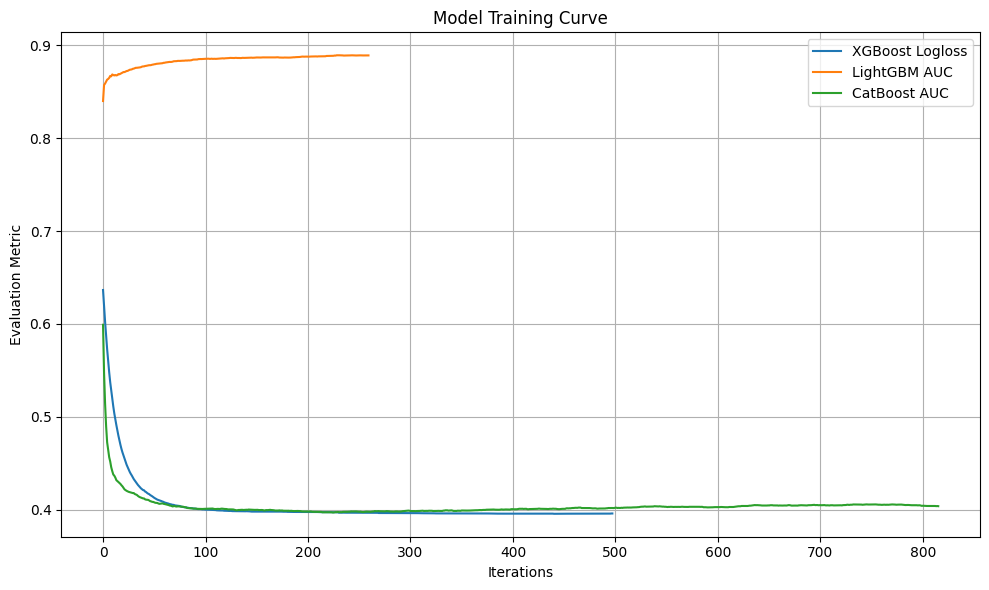

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(xgb_log['validation_0']['logloss'], label='XGBoost Logloss')
plt.plot(lgb_log['valid_0']['auc'], label='LightGBM AUC')
plt.plot(cat_log['validation']['Logloss'], label='CatBoost AUC')
plt.xlabel('Iterations')
plt.ylabel('Evaluation Metric')
plt.title('Model Training Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_curve.png')
plt.show()

### 7.3 特徵重要性分析

分析和比較不同模型的特徵重要性，找出對預測吸菸狀態最有影響力的特徵。

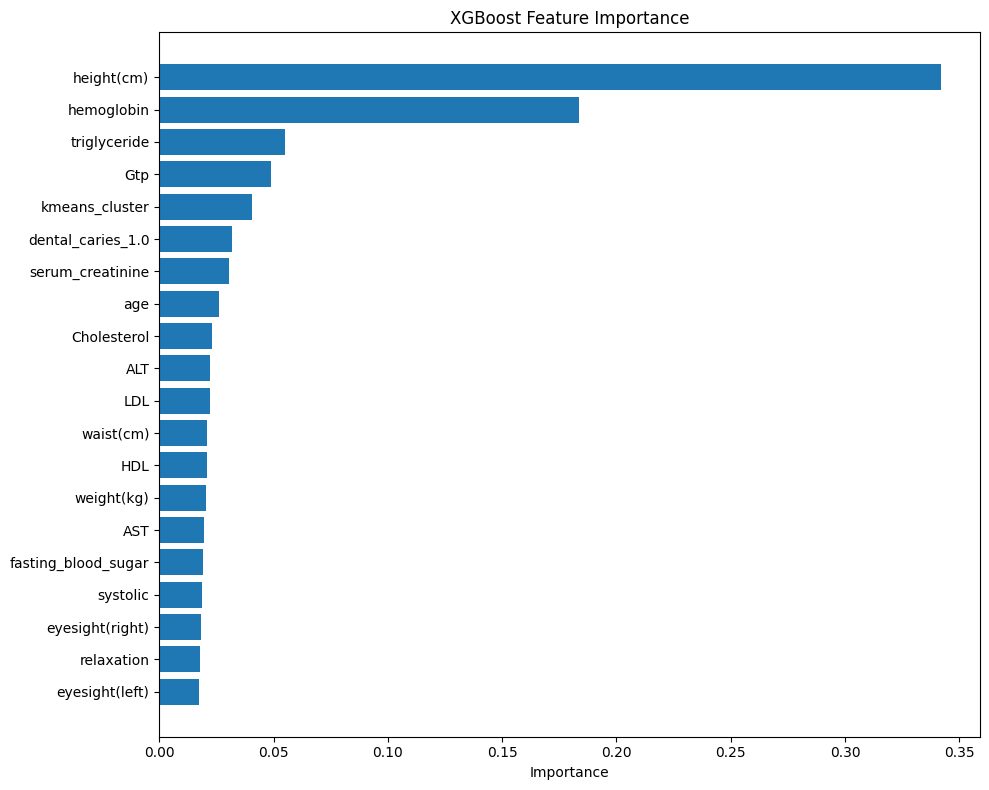

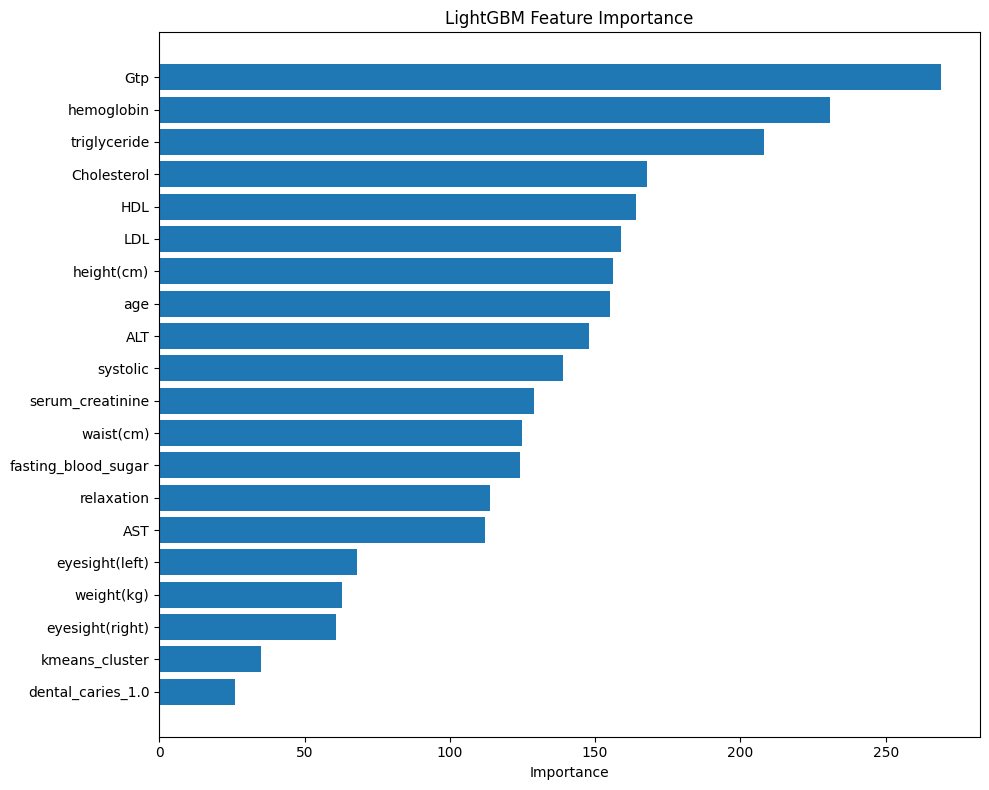

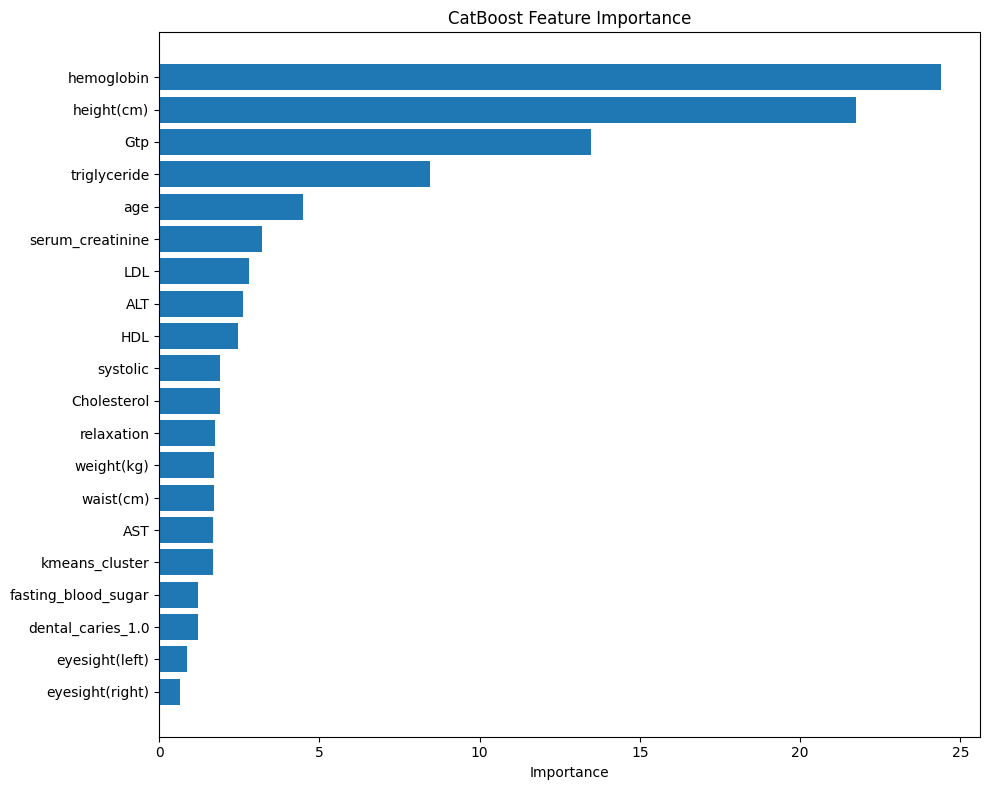

In [54]:
def plot_importance(importances, title, filename):
    df = pd.DataFrame({'Feature': features, 'Importance': importances})
    df = df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 8))
    plt.barh(df['Feature'][:20][::-1], df['Importance'][:20][::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Plot XGBoost feature importance
plot_importance(best_xgb.feature_importances_, "XGBoost Feature Importance", "feature_importance_xgb.png")

# Plot LightGBM feature importance
plot_importance(best_lgb.feature_importances_, "LightGBM Feature Importance", "feature_importance_lgb.png")

# Plot CatBoost feature importance
plot_importance(best_cat.get_feature_importance(), "CatBoost Feature Importance", "feature_importance_cat.png")

### 7.4 SHAP 值分析

使用 SHAP (SHapley Additive exPlanations) 來理解模型的決策過程和特徵對預測的影響。

In [ ]:
# 使用 XGBoost 模型進行 SHAP 值計算
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_val)

# 繪製 SHAP 摘要圖
shap.summary_plot(shap_values, X_val, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot.png")
plt.show()